# Building a fine-tuned translation system for English-Malayalam

- toc: true
- branch: master
- badges: true
- hide_binder_badge: true
- comments: true
- author: Kurian Benoy
- categories: [fastai, huggingface, translation, fine tuning, malayalam]
- search_exclude: false
- hide: false



Hey, everyone. We all are familiar with translation systems like using google translate. Let's build a fine tuned translation system for converting text from english to malayalam. It's build using
 Blurr library - build on top of hugging face and fastai. Also it's being fine tuned on [top of KDE - Dataset](https://huggingface.co/datasets/kde4).


![Google Translate](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Screenshot_of_Google_Translate.png/1200px-Screenshot_of_Google_Translate.png)



If you want to try it out, check out hugging face model which will be updated shortly.

In [2]:
#hide
! pip install datasets -Uqq
! pip install transformers[sentencepiece] -Uqq
! pip install git+https://github.com/ohmeow/blurr.git@dev-2.0.0 -Uqq
! pip install -U nltk -Uqq
! pip install sacrebleu -Uqq

     |████████████████████████████████| 312 kB 5.2 MB/s 
     |████████████████████████████████| 134 kB 44.9 MB/s 
     |████████████████████████████████| 212 kB 47.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.9 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 127 kB 53.6 MB/s 
     |████████████████████████████████| 144 kB 45.5 MB/s 
     |████████████████████████████████| 271 kB 50.1 MB/s 
     |████████████████████████████████| 94 kB 1.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 37.6 MB/s 
     |████████████████████████████████| 596 kB 51.1 MB/s 
     |████████████████████████████████| 6.5

---
## Loading Data

A translation system is an example of sequence to sequence models, which is usually used for tasks which involves generating new data. Translation usually needs dataset in both the source language and target language(the language to which it's needs to be translated.

We are using KDE4 dataset, and choose both source language and translation language which was done probably translated by KDE community members in Kerala.

In [3]:
import pandas 
from datasets import load_dataset

In [4]:
raw_datasets = load_dataset("kde4", lang1="en", lang2="ml", split="train[:1000]")

Downloading:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Using custom data configuration en-ml-lang1=en,lang2=ml


Downloading:   0%|          | 0.00/924k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset kde4 downloaded and prepared to /root/.cache/huggingface/datasets/kde4/en-ml-lang1=en,lang2=ml/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac. Subsequent calls will reuse this data.


Most of translation dataset is in form of id and translation json output - with both `en and ml` as objects.

In [5]:
raw_datasets[0]

{'id': '0',
 'translation': {'en': 'Add Feed to Akregator',
  'ml': 'അക്രിഗേറ്ററില്\u200d ഫീഡ് കൂട്ടിച്ചേര്\u200dക്കുക'}}

---
## Transforming data into DataLoaders

### Importing libraries and get hugging-face objects

In [6]:
from blurr.data.all import *
from blurr.modeling.all import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.learner import *
from fastai.optimizer import *
from transformers import *

Downloading:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

In [7]:
pretrained_model_name = "Helsinki-NLP/opus-mt-en-ml"
model_cls = AutoModelForSeq2SeqLM
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/600k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/934k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/219M [00:00<?, ?B/s]

('marian',
 transformers.models.marian.configuration_marian.MarianConfig,
 transformers.models.marian.tokenization_marian.MarianTokenizer,
 transformers.models.marian.modeling_marian.MarianMTModel)

In [8]:
translation_df = pd.DataFrame(raw_datasets["translation"], columns=["en", "ml"])
translation_df.head()

,en,ml
0,Add Feed to Akregator,അക്രിഗേറ്ററില്‍ ഫീഡ് കൂട്ടിച്ചേര്‍ക്കുക
1,Add Feeds to Akregator,അക്രിഗേറ്ററില്‍ ഫീഡുകള്‍ കൂട്ടിച്ചേര്‍ക്കുക
2,Add All Found Feeds to Akregator,എല്ലാ ഫീഡുകളും അക്രിഗേറ്ററില്‍ കൂട്ടിച്ചേര്‍ക്കുക
3,Subscribe to site updates (using news feed),സൈറ്റുകളിലെ പുതുമകളറിയാന്‍ വരിക്കാരനാകുക (വാര്‍ത്താ ഫീഡുകള്‍ ഉപയോഗിച്ചു്)
4,Imported Feeds,എടുത്ത ഫീഡുകള്‍


In [9]:
blocks = (Seq2SeqTextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader("en"), get_y=ColReader("ml"), splitter=RandomSplitter())

In [10]:
dls = dblock.dataloaders(translation_df, bs=1)
dls.show_batch(dataloaders=dls, max_n=2, input_trunc_at=100, target_trunc_at=250)

,text,target
0,A▁version▁control▁history▁entry▁consists of▁several▁lines.▁Specify the▁regular▁expression▁to▁detect,ഒരു ഭാഷാന്തര നിയന്ത്രണത്തിന്റെ നാള്വഴി ചേര്ക്കുന്നതില് പല വരികളുണ്ടാകും. ആദ്യത്തെ വരി കണ്ടുപിടിക്കാനുള്ള നിത്യഭാവം നിര്ദ്ദേശിക്കുക (മുന്നിലെ വിശദീകരണം കൂടാതെ). ഇനം തിരിക്കാനുപയോഗിക്കുന്ന കീകളെ ഒന്നിച്ചാക്കാന് ബ്രാക്കറ്റുകള് ഉപയോഗിക്കുക. ഒഴിച്ചു വിട്ട


---
## Training fine-tuned translation system

### Using blurr High-level API

In [11]:
learn = BlearnerForTranslation.from_data(
    translation_df,
    pretrained_model_name,
    src_lang_name="English",
    src_lang_attr="en",
    trg_lang_name="Malayalam",
    trg_lang_attr="ml",
    dl_kwargs={"bs": 4},
)

In [12]:
metrics_cb = BlearnerForTranslation.get_metrics_cb()
learn.fit_one_cycle(1, lr_max=4e-5, cbs=[metrics_cb])

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Downloading:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,4.511985,4.454725,0.019409,0.181278,4.058209,00:50


In [13]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,▁You▁have▁clicked▁on▁a▁link▁which▁might▁not▁indicate▁correctly▁where▁you▁are▁really▁going▁to.▁Please▁check▁if▁you▁really▁want▁to▁view▁a▁page▁on▁this▁server:▁%1▁Do▁you▁want▁to▁go▁there?,നിങ്ങള് ഒരു കണ്ണിയില് ഞൊട്ടിയത് നിങ്ങളെവിടേക്കാണ് വാസ്തവത്തില് പോകുന്നത് എന്ന് കൃത്യമായി സൂചിപ്പിക്കുന്നില്ല. ഇ സേവകന്റെ താളിലേക്കു തന്നെ യാണോ പോകേണ്ടതെന്ന് പരിശോധിക്കുക:% 1 നിങ്ങള്ക്കിവിടെ പോകണോ?,"[നിങ്ങൾ track track after track track track: track: track track track, വര്ഷണങ്ങള്ക്കനുസൃതങ്ങള്ക്കു് പരാജയപ്പെട്ടു. ഈ ആജ്ഞ പരിശോധിയ്ക്കുന്ന ആജ്ഞ:% 1 വരിയ്ക്കുന്ന വര്ഷം - പ്രത്യയശാസ്ത്രം പ്രവർത്തന രഹിതമാക്കും., വ്യതിയാനങ്ങള്ക്കായി ലിപിയുടെ ലയന പതിപ്പ് തെരഞ്ഞെടുക്കുന്നു. അക്ഷരരൂപങ്ങള്ക്ക് പിന്തുണയില്ലെങ്കിൽ ഇതു് കാര്യമായി ഒന്നും ചെയ്യുന്നില്ല., മാഗ്നാട്ടണിൽ നിന്നും നേരിട്ട് വാങ്ങുന്ന ഏതെങ്കിലും വാങ്ങ്ഡൌൺ ഡൌൺലോഡ് ചെയ്യുവാൻ നിങ്ങളുടെ ഇമെയിൽ നൽകുക.]"


### Using mid-level of blurr APIs

In [14]:
b = dls.one_batch()

In [15]:
len(b), b[0]["input_ids"].shape, b[1].shape

(2, torch.Size([1, 72]), torch.Size([1, 114]))

In [16]:
dls.show_batch(dataloaders=dls, input_trunc_at=250, target_trunc_at=250)

,text,target
0,"A▁version▁control▁history▁entry▁consists of▁several▁lines.▁Specify the▁regular▁expression▁to▁detect the▁first▁line (without the▁leading▁comment).▁Use▁parentheses▁to▁group the▁keys▁you▁want▁to▁use▁for▁sorting.▁If▁left▁empty,▁then▁KDiff3▁assumes▁that▁e",ഒരു ഭാഷാന്തര നിയന്ത്രണത്തിന്റെ നാള്വഴി ചേര്ക്കുന്നതില് പല വരികളുണ്ടാകും. ആദ്യത്തെ വരി കണ്ടുപിടിക്കാനുള്ള നിത്യഭാവം നിര്ദ്ദേശിക്കുക (മുന്നിലെ വിശദീകരണം കൂടാതെ). ഇനം തിരിക്കാനുപയോഗിക്കുന്ന കീകളെ ഒന്നിച്ചാക്കാന് ബ്രാക്കറ്റുകള് ഉപയോഗിക്കുക. ഒഴിച്ചു വിട്ട


In [17]:
seq2seq_metrics = {"bleu": {"returns": "bleu"}, "meteor": {"returns": "meteor"}, "sacrebleu": {"returns": "score"}}

model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),  # CrossEntropyLossFlat()
    cbs=learn_cbs,
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
)

learn.freeze()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


SuggestedLRs(minimum=2.2908675418875645e-07, steep=1.5848931980144698e-06, valley=0.00010964782268274575, slide=7.585775892948732e-05)

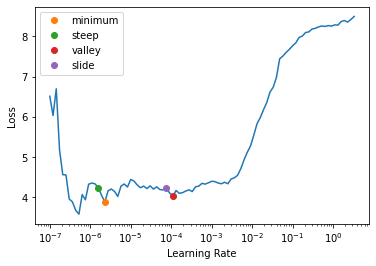

In [18]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [20]:
learn.fit_one_cycle(3, lr_max=0.00010964782268274575, cbs=fit_cbs)

epoch,train_loss,valid_loss,bleu,meteor,sacrebleu,time
0,2.893481,3.165542,0.033283,0.154091,3.405915,02:14
1,2.559106,2.974938,0.063900,0.175575,5.129397,02:15
2,1.869298,2.892835,0.059192,0.174119,4.500239,02:17


In [21]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=500)

,text,target,prediction
0,"▁To▁prevent▁data▁loss▁or▁other▁damage,▁you▁can▁have the▁system suspend▁or▁hibernate,▁so▁you▁do▁not▁accidentally▁run▁out of▁battery▁power.▁Configure the▁number of▁minutes▁below▁which the▁machine▁will▁run the▁configured▁action.","വിവരനഷ്ടമോ ഹാനിയോ തടയാന്, സിസ്റ്റം മയങ്ങുകയോ ശിശിരനിദ്രയിലാകുകയോചെയ്യാവുന്നതാണ്, അങ്ങനെ ആകസ്മികമായിട്ടുപോലും ബാറ്ററി ഊര്ജ്ജം തീരാതിരിയ്ക്കും. ക്രമീകരിച്ച നടപടിയുമായി മുന്നോട്ടു് പോകേണ്ടതു് എത്ര മിനിറ്റുകളില് താഴെയാകുമ്പോഴാണെന്നു് താഴെ ക്രമീകരിയ്ക്കുക.","ഡാറ്റയുടെ നഷ്ടപരിഹാരം തടയാനായി, സിസ്റ്റം മയങ്ങാനോ മിച്ചിക്കാനോ സാധിക്കും, അതിനാൽ ബാറ്ററിയിലെ ഊര്യുണ്ടായിട്ടില്ല. മെയിലഡി ക്രമീകരിക്കപ്പെടുന്ന ഒരു മിനിട്ടിന്റെ എണ്ണം ക്രമീകരിക്കുക. @ title: window token for playlist column name and token for playlist layouts token token token token token token token toplayouts."


---
## Now let's translate with our trained models

### blurr top 5 translation predictions

In [22]:
test_text = "How are you doing"


outputs = learn.blurr_generate(test_text, key="translation_texts", num_return_sequences=3)
outputs

[{'translation_texts': ['എന്തൊക്കെയുണ്ട്?',
   'സുഖമാണോ?',
   'എന്തൊക്കെയുണ്ട് വിശേഷം?']}]

### Saving trained ML model

In [23]:
export_fname = "saved_model"


learn.metrics = None
learn.export(fname=f"{export_fname}.pkl")

### Prediction with our trained model

In [24]:
test_text = "How are you doing"

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_text)

[{'translation_texts': 'എന്തൊക്കെയുണ്ട്?'}]

In [25]:
test_text1 = "I am not so proficent in english."

inf_learn = load_learner(fname=f"{export_fname}.pkl")
inf_learn.blurr_translate(test_text1)

[{'translation_texts': '@ title: window'}]

fin.